# Requirements

In [4]:
# Standard library imports
import os
import random

# Scientific computing
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

# Computer Vision and Image Processing
from PIL import Image
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm


# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# JSON and datetime for logging
import json
from datetime import datetime

# Config

- Central place to define all key settings for the notebook.
- Stores paths (like data directory), image size, batch size, epochs, learning rate, and class names.
- Handles device selection (CPU/MPS) and train/validation split ratio.
- Makes code cleaner, easier to update, and ensures consistency.
- Changing a value in the config updates it everywhere in the notebook.

In [5]:
# Configuration class for all hyperparameters and paths
class Config:
    DATA_DIR = '/Users/rishi/Desktop/Assignment-II (2)/Data'  # Path to your dataset
    IMAGE_SIZE = (224, 224)                            # Image size for resizing
    BATCH_SIZE = 32                                    # Batch size for DataLoader
    EPOCHS = 50                                        # Number of training epochs
    LEARNING_RATE = 0.001                              # Initial learning rate
    CLASSES = ['Major_scrach', 'Minor_scrach', 'no_scrach']                # List of class names
    NUM_CLASSES = len(CLASSES)                         # Number of classes
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use MPS if available, else CPU
    TRAIN_SPLIT = 0.8                                  # Train/validation split ratio
    NUM_WORKERS = 4                                    # Number of DataLoader workers

# Instantiate the configuration
config = Config()


# Load the Data

This section covers the complete data preparation pipeline for training and validating deep learning models:

- **Load Dataset:** Loads the image dataset using `ImageFolder` and extracts class labels for stratified splitting.
- **Stratified Split:** Splits the dataset into training and validation sets while maintaining class proportions.
- **Image Transformations:** 
    - Applies data augmentation (random flips, rotations, color jitter, etc.) to the training set.
    - Applies normalization and resizing to both training and validation sets.
- **Dataset Creation:** Wraps the transformed images into PyTorch `Subset` datasets for train and validation splits.
- **DataLoader Wrapping:** Uses `DataLoader` for efficient batch loading and shuffling (for training).
- **Dataset Statistics:** Prints sample counts and class distributions for both splits.
- **Verification:** Checks data loading and batch shapes to ensure correctness.

In [6]:
def load_initial_dataset():
    """Load the initial dataset to get labels for stratification"""
    # Load the full dataset using ImageFolder
    full_dataset = ImageFolder(config.DATA_DIR)
    # Extract labels for each sample (used for stratified splitting)
    labels = [label for _, label in full_dataset.samples]
    # Get the list of class names
    classes = full_dataset.classes

    # Print dataset statistics
    print(f"Total samples: {len(full_dataset)}")
    print(f"Number of classes: {len(classes)}")
    print("Classes:", classes)

    return full_dataset, labels, classes

In [7]:
def create_stratified_split(full_dataset, labels):
    """Create stratified train-validation split"""
    # Get indices for all samples
    indices = np.arange(len(labels))
    
    # Perform stratified split to maintain class proportions in train/val sets
    train_indices, val_indices = train_test_split(
        indices,
        train_size=config.TRAIN_SPLIT,   # Proportion of data to use for training
        stratify=labels,                 # Stratify by class labels
        random_state=42                  # For reproducibility
    )
    
    return train_indices, val_indices

In [ ]:
def get_scratch_transforms():
    """Define training and validation transforms optimized for scratch detection"""
    
    # Calculate resize size (adding 32 to both dimensions)
    resize_size = (config.IMAGE_SIZE[0] + 32, config.IMAGE_SIZE[1] + 32)
    
    train_transforms = transforms.Compose([
        # Maintain aspect ratio better for scratch visibility
        transforms.Resize(resize_size),  # Resize to (256, 256)
        transforms.CenterCrop(config.IMAGE_SIZE),  # Crop to (224, 224)
        
        # Augmentations specific to scratch detection
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),    # Scratches can be in any orientation
        
        # Rotation for scratch orientation variations
        transforms.RandomRotation(
            degrees=45,                          
            fill=0                               
        ),
        
        # Random affine transformation for perspective changes
        transforms.RandomAffine(
            degrees=0,                           
            translate=(0.1, 0.1),                
            scale=(0.8, 1.2),                    
            shear=15                             
        ),
        
        # Color adjustments optimized for scratch visibility
        transforms.ColorJitter(
            brightness=0.4,                      
            contrast=0.4,                        
            saturation=0.2,                      
            hue=0.05                            
        ),
        
        # Random adjustments specific to scratch detection
        transforms.RandomAdjustSharpness(
            sharpness_factor=2,                  
            p=0.5
        ),
        
        transforms.RandomAutocontrast(p=0.5),    
        
        # Convert to tensor and normalize
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Validation transforms
    val_transforms = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    return train_transforms, val_transforms



In [19]:
def create_datasets_with_transforms(train_indices, val_indices):
    """Create datasets with appropriate transforms"""
    # Get data augmentation and normalization transforms for train/val
    train_transforms, val_transforms = get_scratch_transforms()
    
    # Create ImageFolder datasets with transforms applied
    train_dataset = ImageFolder(
        root=config.DATA_DIR,
        transform=train_transforms
    )
    val_dataset = ImageFolder(
        root=config.DATA_DIR,
        transform=val_transforms
    )
    
    # Use Subset to select only the indices for train/val split
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)
    
    return train_dataset, val_dataset


In [28]:
def create_dataloaders(train_dataset, val_dataset):
    """Create train and validation dataloaders"""
    # DataLoader for training set (shuffling enabled)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )
    
    # DataLoader for validation set (no shuffling)
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [29]:
def print_dataset_stats(train_dataset, val_dataset, classes):
    """Print detailed dataset statistics"""
    print("\nDataset Statistics:")
    print(f"Total samples: {len(train_dataset) + len(val_dataset)}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Get class distribution for training and validation sets
    train_labels = [train_dataset.dataset.targets[idx] for idx in train_dataset.indices]
    val_labels = [val_dataset.dataset.targets[idx] for idx in val_dataset.indices]
    
    print("\nClass distribution:")
    print("Class\t\tTrain\tValidation\tRatio")
    print("-" * 50)
    
    # Print class-wise counts and train/val ratio
    for i, class_name in enumerate(classes):
        train_count = train_labels.count(i)
        val_count = val_labels.count(i)
        ratio = train_count / val_count if val_count > 0 else 0
        print(f"{class_name:<15} {train_count:>5} {val_count:>10} {ratio:>10.2f}")

In [22]:
def verify_data_loading(train_loader, val_loader):
    """Verify data loading and shapes"""
    print("\nVerifying data loading:")
    
    # Check a batch from the training loader
    images, labels = next(iter(train_loader))
    print("\nTraining batch:")
    print(f"Image batch shape: {images.shape}")  # Shape of image batch (batch_size, channels, height, width)
    print(f"Labels batch shape: {labels.shape}")  # Shape of label batch (batch_size,)
    print(f"Images dtype: {images.dtype}")        # Data type of images (should be torch.float32)
    print(f"Labels unique values: {torch.unique(labels)}")  # Unique class labels in the batch
    
    # Check a batch from the validation loader
    images, labels = next(iter(val_loader))
    print("\nValidation batch:")
    print(f"Image batch shape: {images.shape}")   # Shape of image batch (batch_size, channels, height, width)
    print(f"Labels batch shape: {labels.shape}")  # Shape of label batch (batch_size,)
    print(f"Images dtype: {images.dtype}")        # Data type of images (should be torch.float32)
    print(f"Labels unique values: {torch.unique(labels)}")  # Unique class labels in the batch

In [27]:
# Load initial dataset and extract labels/classes for stratified splitting
full_dataset, labels, classes = load_initial_dataset()

# Create stratified train/validation split indices
train_indices, val_indices = create_stratified_split(full_dataset, labels)

# Create training and validation datasets with appropriate transforms
train_dataset, val_dataset = create_datasets_with_transforms(
    train_indices, 
    val_indices
)

# Create DataLoader objects for training and validation sets
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)

# Print dataset statistics (sample counts, class distribution, etc.)
print_dataset_stats(train_dataset, val_dataset, classes)

# Verify that data loading works and check batch shapes/types
verify_data_loading(train_loader, val_loader)


Total samples: 304
Number of classes: 3
Classes: ['MAJORSCRACH', 'MINOR_SCRACH', 'NO_SCRACH']

Dataset Statistics:
Total samples: 304
Training samples: 243
Validation samples: 61

Class distribution:
Class		Train	Validation	Ratio
--------------------------------------------------
MAJORSCRACH        80         20       4.00
MINOR_SCRACH       83         21       3.95
NO_SCRACH          80         20       4.00

Verifying data loading:

Training batch:
Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Images dtype: torch.float32
Labels unique values: tensor([0, 1, 2])

Validation batch:
Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Images dtype: torch.float32
Labels unique values: tensor([0, 1, 2])


# Visualise the Dataset

- **Purpose:** Display random sample images from each class in both training and validation datasets.
- **Why:** Helps visually inspect data quality, class balance, and effects of preprocessing/augmentation.
- **How:** 
    - Uses denormalization to show images in natural colors.
    - Samples are drawn per class for both splits.
- **Benefits:** 
    - Quickly verify correct data loading.
    - Check for class imbalance.
    - Inspect if augmentations are applied as expected.

In [30]:
def denormalize_image(image):
    """Denormalize the image tensor for visualization (undo normalization)."""
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return image * std + mean

def display_samples(dataset, classes, samples_per_class=5, title=""):
    """
    Display sample images for each class from a dataset.

    Args:
        dataset: PyTorch dataset or Subset.
        classes: List of class names.
        samples_per_class: Number of images to display per class.
        title: Title for the plot.
    """
    fig = plt.figure(figsize=(12, 4 * len(classes)))
    
    for class_idx, class_name in enumerate(classes):
        # Get indices for this class
        if hasattr(dataset, 'indices'):
            # For Subset datasets, map indices to original targets
            class_indices = [i for i, idx in enumerate(dataset.indices) 
                             if dataset.dataset.targets[idx] == class_idx]
        else:
            # For regular datasets
            class_indices = [i for i, (_, label) in enumerate(dataset) 
                             if label == class_idx]
        
        # Randomly sample images from this class
        sample_indices = np.random.choice(
            class_indices, 
            min(samples_per_class, len(class_indices)), 
            replace=False
        )
        
        # Display images for this class
        for i, idx in enumerate(sample_indices):
            img, _ = dataset[idx]
            img = denormalize_image(img)  # Undo normalization for display
            
            plt.subplot(len(classes), samples_per_class, 
                        class_idx * samples_per_class + i + 1)
            
            # Convert tensor to numpy and adjust shape for imshow
            img = img.numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
            
            plt.imshow(img)
            if i == 0:  # Show class name only for first image in row
                plt.title(f'{class_name}')
            plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


Training Samples:


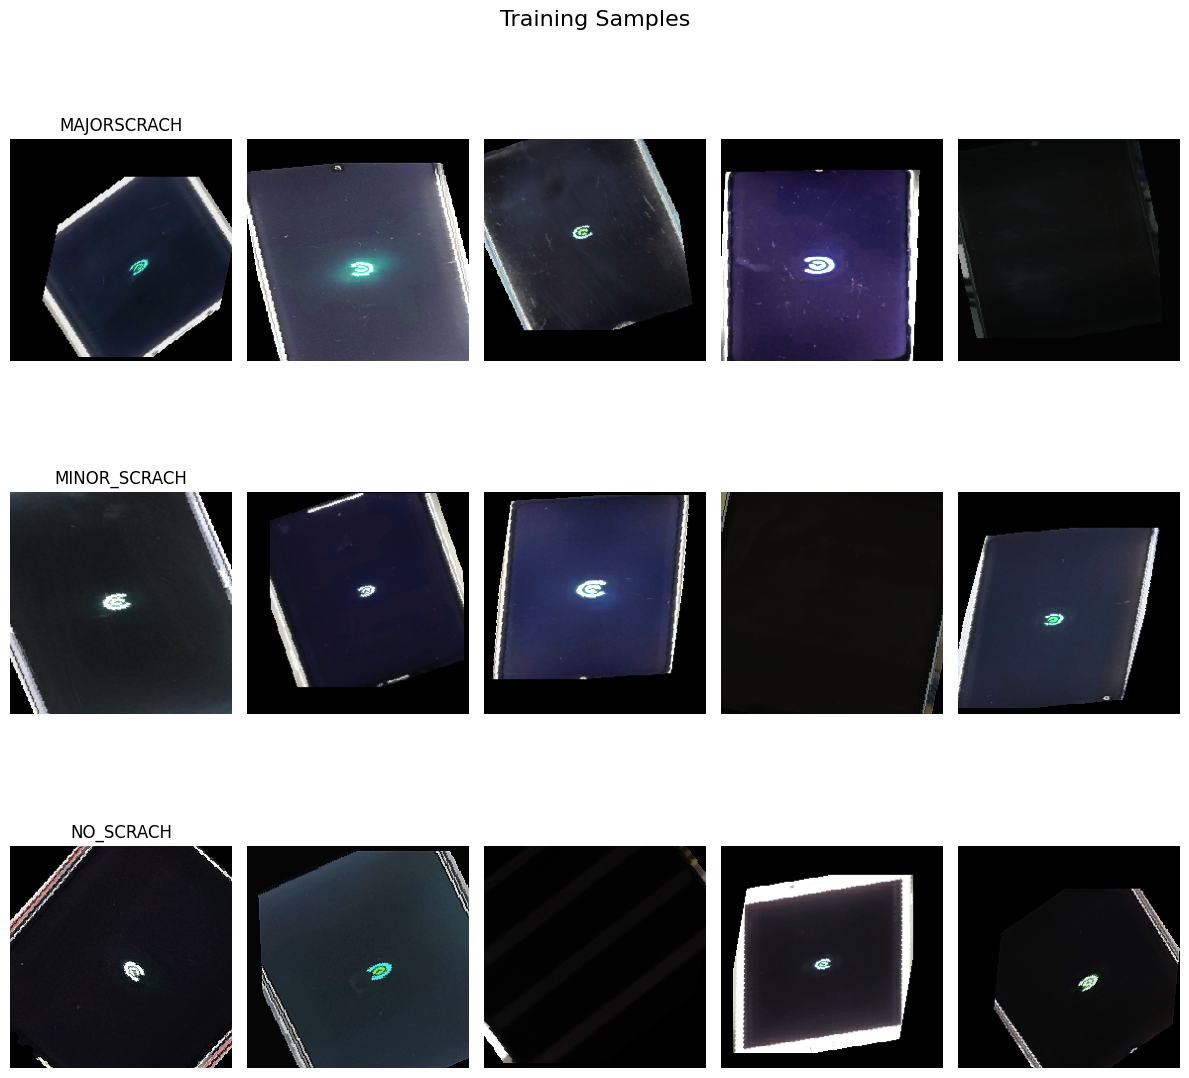


Validation Samples:


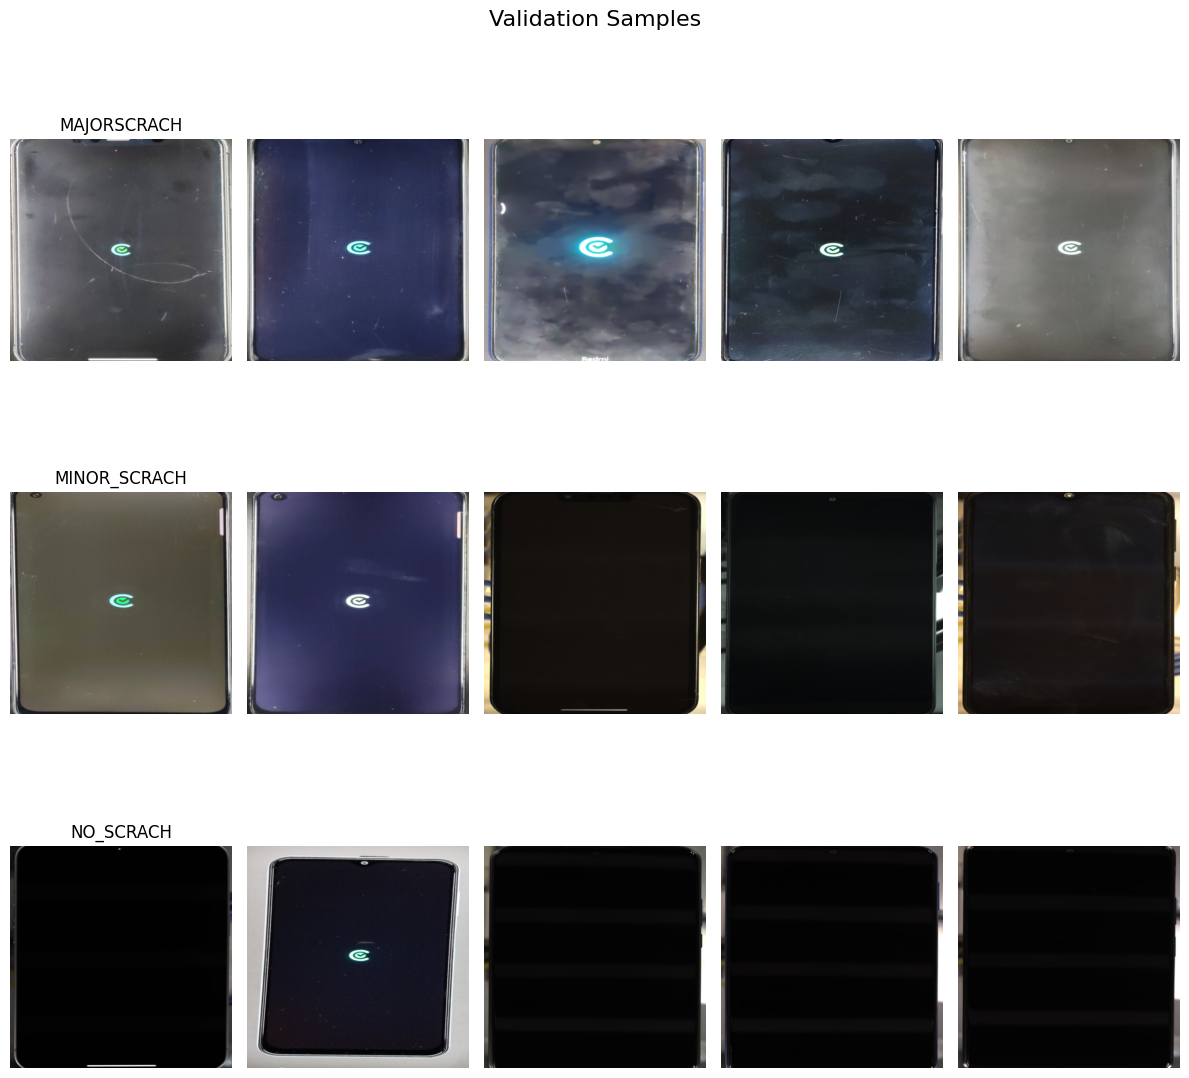

In [32]:
#""Show samples from both training and validation sets"""
print("Training Samples:")
display_samples(train_dataset, classes, title="Training Samples")

print("\nValidation Samples:")
display_samples(val_dataset, classes, title="Validation Samples")

## Architectures Used in This Notebook

This notebook explores and compares several deep learning architectures for scratch classification:

---

### 1. **ResNet50 (Custom Head)**
- **Base:** Pretrained ResNet50 as feature extractor.
- **Classifier:** Custom fully connected layers with BatchNorm, PReLU, and Dropout.
- **Purpose:** Strong baseline for image classification.

---

### 2. **WearNet + ResNet50 Backbone**
- **Base:** ResNet50 (pretrained, most layers frozen except last block).
- **Classifier:** WearNet-style head (multiple dense layers with BatchNorm, PReLU, Dropout).
- **Purpose:** Combines robust ResNet50 features with a custom classifier for improved performance.

---

### 3. **WearNet + DenseNet121 Backbone**
- **Base:** DenseNet121 (pretrained, most layers frozen except last block).
- **Classifier:** WearNet-style head (same as above).
- **Purpose:** Leverages DenseNet's dense connectivity for feature extraction, combined with WearNet classifier.

---

### 4. **MobileNetV2 (Custom Head)**
- **Base:** Pretrained MobileNetV2 as feature extractor.
- **Classifier:** Custom fully connected layers with BatchNorm, PReLU, and Dropout.
- **Purpose:** Lightweight, efficient model suitable for deployment on resource-constrained devices.

---

**Summary Table:**

| Model Name                | Backbone      | Custom Classifier | Notes                        |
|-------------------------- |--------------|-------------------|------------------------------|
| ResNet50 Custom           | ResNet50      | Yes               | Strong baseline              |
| WearNet + ResNet50        | ResNet50      | WearNet Head      | Custom head, partial fine-tune|
| WearNet + DenseNet121     | DenseNet121   | WearNet Head      | Custom head, partial fine-tune|
| MobileNetV2 Custom        | MobileNetV2   | Yes               | Lightweight, efficient       |

All models are trained and evaluated for scratch classification, allowing direct comparison of their performance.


In [33]:
class ResNet50Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet50Custom, self).__init__()
        # Load pretrained ResNet50 as the base model
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze early layers to retain pretrained features
        for param in list(self.base_model.parameters())[:-14]:
            param.requires_grad = False
        # Unfreeze last 6 layers for fine-tuning
        for param in list(self.base_model.parameters())[-14:]:
            param.requires_grad = True
            
        # Remove the original fully connected classifier
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        
        # Custom classifier head with batch norm, PReLU, and dropout
        self.custom_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Forward through base model (feature extractor)
        x = self.base_model(x)
        # Forward through custom classifier head
        x = self.custom_classifier(x)
        return x

In [ ]:
# generate_multiclass_masks.py
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

def create_multiclass_masks(data_dir, mask_dir, classes):
    os.makedirs(mask_dir, exist_ok=True)
    class_to_label = {cls: idx for idx, cls in enumerate(classes)}

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        image_paths = glob(os.path.join(cls_path, "*.png"))

        for img_path in tqdm(image_paths, desc=f"Generating mask for {cls}"):
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read: {img_path}")
                continue

            h, w = img.shape[:2]
            mask = np.zeros((h, w), dtype=np.uint8)

            # Create circular blob in center with class label as value
            cv2.circle(mask, (w // 2, h // 2), min(h, w) // 4, class_to_label[cls], -1)

            # Save mask
            base = os.path.basename(img_path).replace(".png", "_mask.png")
            save_path = os.path.join(mask_dir, base)
            cv2.imwrite(save_path, mask)

# Run the script with your paths
create_multiclass_masks(
    data_dir="/Users/rishi/Desktop/Assignment-II (2)/Data",
    mask_dir="/Users/rishi/Desktop/Assignment-II (2)/masks",
    classes=["MAJORSCRACH", "MINOR_SCRACH", "NO_SCRACH"]
)


Generating mask for NO_SCRACH: 100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


In [34]:
class MobileNetV2Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(MobileNetV2Custom, self).__init__()
        # Load pretrained MobileNetV2 as the base model
        self.base_model = models.mobilenet_v2(pretrained=True)
        
        # Freeze early layers, unfreeze last 8 layers for fine-tuning
        for param in list(self.base_model.parameters())[:-14]:
            param.requires_grad = False
        for param in list(self.base_model.parameters())[-14:]:
            param.requires_grad = True
        
        # Get the number of output features from the base model
        num_ftrs = self.base_model.last_channel
        
        # Custom classifier head with batch norm, PReLU, and dropout
        self.custom_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),             # Flatten to (batch, features)
            
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, num_classes)  # Output layer
        )
        
    def forward(self, x):
        # Forward through base model's feature extractor
        x = self.base_model.features(x)
        # Forward through custom classifier head
        x = self.custom_classifier(x)
        return x

In [35]:
class WearNetWithBackbone(nn.Module):
    def __init__(self, num_classes, backbone='resnet50', dropout_rate=0.5):
        super(WearNetWithBackbone, self).__init__()
        
        # Choose backbone
        self.backbone_name = backbone
        self.backbone = self._get_backbone(backbone)
        
        # Get number of features from backbone
        if 'resnet' in backbone:
            num_features = self.backbone.fc.in_features
            # Remove the final fully connected layer
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        elif 'densenet' in backbone:
            num_features = self.backbone.classifier.in_features
            # Remove the final classifier
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
            
        # Custom classifier head (WearNet specific)
        self.custom_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),    
            nn.Flatten(),               
            
            # First dense block
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            # Second dense block
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            # Third dense block
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.PReLU(),
            nn.Dropout(0.4),
            
            # Output layer
            nn.Linear(128, num_classes)
        )
        
        # Freeze backbone layers
        self._freeze_backbone()
        
    def _get_backbone(self, backbone_name):
        """Get pretrained backbone model"""
        if backbone_name == 'resnet50':
            return models.resnet50(pretrained=True)
        elif backbone_name == 'densenet121':
            return models.densenet121(pretrained=True)
        else:
            raise ValueError(f"Backbone {backbone_name} not supported")
    
    def _freeze_backbone(self):
        """Freeze backbone layers"""
        # Freeze all backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Optionally unfreeze the last few layers
        if 'resnet' in self.backbone_name:
            # Unfreeze the last residual block
            for param in list(self.backbone.parameters())[-20:]:
                param.requires_grad = True
        elif 'densenet' in self.backbone_name:
            # Unfreeze the last dense block
            for param in list(self.backbone.parameters())[-30:]:
                param.requires_grad = True
    
    def forward(self, x):
        # Forward through backbone
        x = self.backbone(x)
        # Forward through classifier
        x = self.custom_classifier(x)
        return x

# Set Up the Hyperparameters

This section provides utility functions and setup for robust model training, especially for handling class imbalance.

- **`get_class_weights`**:  
    Calculates class weights based on the frequency of each class in the training data. This helps address class imbalance by assigning higher weights to underrepresented classes.

- **`FocalLoss`**:  
    Implements the Focal Loss function, which focuses training on hard-to-classify examples. This is particularly useful for imbalanced datasets, as it down-weights easy examples and prevents the model from being overwhelmed by the majority class.

- **`setup_model`**:  
    Prepares the model for training by:
    - Moving it to the correct device (CPU/MPS).
    - Applying class weights to the loss function.
    - Setting up the optimizer with different learning rates for the backbone and custom classifier (if applicable).
    - Configuring a learning rate scheduler for adaptive training.

These utilities ensure a fair and effective training process, especially when dealing with real-world, imbalanced datasets.

In [36]:
def get_class_weights(train_dataset):
    """
    Calculate class weights for imbalanced dataset.
    Returns a tensor of weights inversely proportional to class frequencies.
    """
    # Extract labels from the dataset (handles both Subset and regular datasets)
    if hasattr(train_dataset, 'indices'):
        labels = [train_dataset.dataset.targets[idx] for idx in train_dataset.indices]
    else:
        labels = train_dataset.targets

    # Count number of samples per class
    class_counts = torch.bincount(torch.tensor(labels))
    total_samples = len(labels)

    # Compute weights: inverse frequency for each class
    weights = total_samples / (len(class_counts) * class_counts.float())
    return weights

In [37]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss for addressing class imbalance by focusing on hard examples.

        Args:
            weight (Tensor, optional): Class weights for balancing.
            gamma (float): Focusing parameter for modulating factor (1-pt).
            reduction (str): Specifies the reduction to apply to the output: 'mean', 'sum', or 'none'.
        """
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input, target):
        """
        Compute the focal loss between input logits and target labels.

        Args:
            input (Tensor): Predicted logits (batch_size, num_classes).
            target (Tensor): Ground truth labels (batch_size).

        Returns:
            Tensor: Computed focal loss.
        """
        # Compute standard cross entropy loss (no reduction)
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        # Compute pt (probability of the true class)
        pt = torch.exp(-ce_loss)
        # Apply focal loss formula
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        
        # Apply reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [38]:
def setup_model(model, train_dataset, weight_decay=0.01):
    """
    Setup model with appropriate loss function and optimizer
    
    Args:
        model: Pre-initialized PyTorch model
        train_dataset: Training dataset for calculating class weights
        weight_decay: Weight decay for optimizer (default: 0.01)
    
    Returns:
        tuple: (model, criterion, optimizer, scheduler)
    """
    # Move model to the correct device (CPU, CUDA, or MPS)
    model = model.to(config.DEVICE)
    
    # Calculate class weights for imbalanced datasets
    class_weights = get_class_weights(train_dataset).to(config.DEVICE)
    
    # Use FocalLoss with class weights to handle class imbalance
    criterion = FocalLoss(weight=class_weights)
    
    # Set up optimizer with different learning rates for base and custom classifier
    try:
        params = [
            # Lower learning rate for pretrained base model
            {'params': model.base_model.parameters(), 'lr': config.LEARNING_RATE * 0.1},
            # Higher learning rate for custom classifier layers
            {'params': model.custom_classifier.parameters(), 'lr': config.LEARNING_RATE}
        ]
    except AttributeError:
        # Fallback: use a single learning rate if model structure is different
        params = model.parameters()
    
    optimizer = torch.optim.AdamW(params, weight_decay=weight_decay)
    
    # Learning rate scheduler: reduce LR on plateau of validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5
    )
    
    return model, criterion, optimizer, scheduler

# Training Loop

This section implements the main training loop for deep learning models with robust features:

- **Early Stopping & Checkpointing:**  
    Stops training when validation loss stops improving and saves the best model automatically.

- **Metrics Tracking:**  
    Logs training/validation loss, accuracy, and learning rate for each epoch.

- **Comprehensive Logging:**  
    Stores all training metrics and status to disk for reproducibility and later analysis.

- **Error Handling & Resume Support:**  
    Handles interruptions gracefully and supports resuming training.

- **Summary Report:**  
    Prints a summary of the training process, including best epoch and validation performance.

This ensures reliable, efficient, and transparent model training for your experiments.

In [39]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=30, device='cuda', patience=8, tolerance=1e-4, 
                save_dir='training_runs', run_name=None):
    """
    Train a model with early stopping, comprehensive logging, and checkpointing.
    """
    
    # Create run name if not provided
    if run_name is None:
        run_name = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    # Create directory structure for saving outputs
    base_dir = os.path.join(save_dir, run_name)
    model_dir = os.path.join(base_dir, 'models')
    metrics_dir = os.path.join(base_dir, 'metrics')
    status_dir = os.path.join(base_dir, 'status')
    
    # Create all directories if they don't exist
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(metrics_dir, exist_ok=True)
    os.makedirs(status_dir, exist_ok=True)
    
    # Define file paths for saving model, metrics, and status
    model_save_path = os.path.join(model_dir, 'best_model.pth')
    metrics_file_path = os.path.join(metrics_dir, 'training_metrics.json')
    status_file_path = os.path.join(status_dir, 'training_status.json')
    
    # Initialize dictionary to store training metrics
    training_metrics = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'learning_rates': [],
        'start_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'best_val_loss': float('inf'),
        'best_epoch': 0,
        'early_stopping_epoch': None,
        'model_save_path': model_save_path,
        'run_name': run_name,
        'save_directory': base_dir,
        'early_stopping_settings': {
            'patience': patience,
            'tolerance': tolerance
        }
    }
    
    # Initialize dictionary to track training status
    status = {
        'current_epoch': 0,
        'total_epochs': num_epochs,
        'status': 'starting',
        'last_updated': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'progress_percentage': 0.0,
        'early_stopping': {
            'counter': 0,
            'best_val_loss': float('inf'),
            'patience': patience,
            'tolerance': tolerance,
            'epochs_without_improvement': 0
        }
    }
    
    # Save initial status to file
    with open(status_file_path, 'w') as f:
        json.dump(status, f, indent=4)
    
    # Early stopping variables
    counter = 0
    best_val_loss = float('inf')
    
    print(f"Training started. Files will be saved to: {base_dir}")
    print(f"Early stopping settings - Patience: {patience}, Tolerance: {tolerance}")
    
    try:
        for epoch in range(num_epochs):
            # Training Phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            # Iterate over training batches
            for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += targets.size(0)
                train_correct += (predicted == targets).sum().item()
            
            # Calculate average training loss and accuracy
            train_loss = train_loss / len(train_loader)
            train_accuracy = 100 * train_correct / train_total
            
            # Validation Phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            # Iterate over validation batches
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += targets.size(0)
                    val_correct += (predicted == targets).sum().item()
            
            # Calculate average validation loss and accuracy
            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * val_correct / val_total
            
            # Store metrics for this epoch
            training_metrics['train_losses'].append(train_loss)
            training_metrics['val_losses'].append(val_loss)
            training_metrics['train_accuracies'].append(train_accuracy)
            training_metrics['val_accuracies'].append(val_accuracy)
            training_metrics['learning_rates'].append(optimizer.param_groups[0]['lr'])
            
            # Update learning rate scheduler if provided
            if scheduler:
                scheduler.step(val_loss)
            
            # Early stopping check with tolerance
            if val_loss < (best_val_loss - tolerance):
                best_val_loss = val_loss
                counter = 0
                
                # Save best model checkpoint
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy,
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy
                }
                torch.save(checkpoint, model_save_path)
                
                # Update best metrics
                training_metrics['best_val_loss'] = val_loss
                training_metrics['best_epoch'] = epoch + 1
                
                print(f'New best model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}')
            else:
                counter += 1
                if counter >= patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    training_metrics['early_stopping_epoch'] = epoch + 1
                    break
            
            # Update status dictionary
            status.update({
                'current_epoch': epoch + 1,
                'current_train_loss': train_loss,
                'current_train_accuracy': train_accuracy,
                'current_val_loss': val_loss,
                'current_val_accuracy': val_accuracy,
                'current_lr': optimizer.param_groups[0]['lr'],
                'progress_percentage': ((epoch + 1) / num_epochs) * 100,
                'last_updated': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'early_stopping': {
                    'counter': counter,
                    'best_val_loss': best_val_loss,
                    'patience': patience,
                    'tolerance': tolerance,
                    'epochs_without_improvement': counter
                }
            })
            
            # Save current status and metrics to files
            with open(status_file_path, 'w') as f:
                json.dump(status, f, indent=4)
            with open(metrics_file_path, 'w') as f:
                json.dump(training_metrics, f, indent=4)
            
            # Print epoch summary
            print(f'\nEpoch {epoch+1}/{num_epochs}:')
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
            print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
            print(f'Early Stopping Counter: {counter}/{patience}')
            print('-' * 50)
    
    except Exception as e:
        # Handle exceptions during training
        print(f"Error during training: {str(e)}")
        status['status'] = 'failed'
        status['error'] = str(e)
    
    finally:
        # Final updates after training loop
        end_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        final_status = 'early_stopped' if counter >= patience else 'completed'
        
        # Update final metrics and status
        training_metrics['end_time'] = end_time
        training_metrics['final_status'] = final_status
        
        status.update({
            'status': final_status,
            'last_updated': end_time,
            'training_completed': True,
            'final_metrics': {
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'best_val_loss': best_val_loss,
                'best_epoch': training_metrics['best_epoch']
            }
        })
        
        # Save final metrics and status to files
        with open(metrics_file_path, 'w') as f:
            json.dump(training_metrics, f, indent=4)
        with open(status_file_path, 'w') as f:
            json.dump(status, f, indent=4)
        
        # Save final checkpoint with model and training info
        final_checkpoint_path = os.path.join(model_dir, 'final_checkpoint.pth')
        torch.save({
            'model_class': model.__class__.__name__,  # Save model class name
            'model_params': {  # Save model parameters
                'num_classes': config.NUM_CLASSES,  # Example parameter
                # Add other model initialization parameters here
            },
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'training_metrics': training_metrics,
            'status': status
        }, final_checkpoint_path)
        
        # (NEW) Load best model weights before returning
        if os.path.exists(model_save_path):
            checkpoint = torch.load(model_save_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"\n[INFO] Loaded best model weights from epoch {checkpoint['epoch']}, val loss = {checkpoint['val_loss']:.4f}")
        else:
            print("[WARNING] best_model.pth not found, returning model with final training weights.")
        
        # Print completion summary
        print('\nTraining Summary:')
        print(f'Status: {final_status}')
        print(f'Total Epochs Trained: {epoch + 1}')
        print(f'Best Validation Loss: {best_val_loss:.6f} (Epoch {training_metrics["best_epoch"]})')
        print(f'Final Validation Loss: {val_loss:.6f}')
        print(f'\nFiles saved to: {base_dir}')
        print(f'- Best model: {model_save_path}')
        print(f'- Final checkpoint: {final_checkpoint_path}')
        print(f'- Training metrics: {metrics_file_path}')
        print(f'- Training status: {status_file_path}')
    
    return training_metrics, model


# Plotting Training Metrics

The `plot_metrics` function provides clear visualizations of your model's training process:

- **Loss & Accuracy Curves:**  
    Plots both training and validation loss and accuracy across all epochs, helping you monitor learning progress and detect overfitting.

- **Best Epoch & Early Stopping:**  
    Highlights the epoch with the best validation performance and marks where early stopping occurred, if applicable.

- **Learning Rate Schedule:**  
    Visualizes how the learning rate changed during training, which is useful for understanding the effect of learning rate scheduling.

- **Automatic Saving:**  
    All plots are saved as high-quality image files in a specified directory for future reference.

These visualizations make it easy to analyze model performance, compare experiments, and communicate results effectively.

In [40]:
def plot_metrics(training_metrics, save_dir):
    """
    Plot training and validation metrics from a completed training run.
    Displays plots in the notebook and saves them to disk.
    
    Args:
        training_metrics (dict): Dictionary containing training history
        save_dir (str): Directory where to save the plots
    """
    # Create figures directory
    figures_dir = os.path.join(save_dir, 'figures')
    os.makedirs(figures_dir, exist_ok=True)
    
    # Set basic plotting style
    plt.style.use('default')
    
    # Create two subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Prepare epoch range
    epochs = range(1, len(training_metrics['train_losses']) + 1)
    
    # Plot training and validation loss
    ax1.plot(epochs, training_metrics['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, training_metrics['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    
    # Add vertical line for best epoch if available
    if 'best_epoch' in training_metrics:
        best_epoch = training_metrics['best_epoch']
        ax1.axvline(x=best_epoch, color='g', linestyle='--', 
                    label=f'Best Model (Epoch {best_epoch})')
    
    # Add early stopping line if applicable
    if training_metrics.get('early_stopping_epoch'):
        early_stop = training_metrics['early_stopping_epoch']
        ax1.axvline(x=early_stop, color='r', linestyle='--', 
                    label=f'Early Stopping (Epoch {early_stop})')
    
    # Set loss plot labels and grid
    ax1.set_title('Training and Validation Loss', fontsize=12, pad=10)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.legend(fontsize=8)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot training and validation accuracy
    ax2.plot(epochs, training_metrics['train_accuracies'], 'b-', 
             label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, training_metrics['val_accuracies'], 'r-', 
             label='Validation Accuracy', linewidth=2)
    
    # Add vertical line for best epoch if available
    if 'best_epoch' in training_metrics:
        ax2.axvline(x=best_epoch, color='g', linestyle='--', 
                    label=f'Best Model (Epoch {best_epoch})')
    
    # Add early stopping line if applicable
    if training_metrics.get('early_stopping_epoch'):
        ax2.axvline(x=early_stop, color='r', linestyle='--', 
                    label=f'Early Stopping (Epoch {early_stop})')
    
    # Set accuracy plot labels and grid
    ax2.set_title('Training and Validation Accuracy', fontsize=12, pad=10)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Accuracy (%)', fontsize=10)
    ax2.legend(fontsize=8)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Save and display training metrics plot
    plot_path = os.path.join(figures_dir, 'training_metrics.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    # Create and display learning rate plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_metrics['learning_rates'], 'g-', label='Learning Rate', linewidth=2)
    plt.title('Learning Rate over Epochs', fontsize=12, pad=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Learning Rate', fontsize=10)
    plt.yscale('log')  # Use log scale for learning rate
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save and display learning rate plot
    lr_plot_path = os.path.join(figures_dir, 'learning_rate.png')
    plt.savefig(lr_plot_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    # Print summary of training metrics
    print("\nTraining Metrics Summary:")
    print(f"Number of epochs trained: {len(epochs)}")
    print(f"Best validation loss: {min(training_metrics['val_losses']):.4f} "
          f"(Epoch {training_metrics['best_epoch']})")
    print(f"Final validation loss: {training_metrics['val_losses'][-1]:.4f}")
    print(f"Best validation accuracy: {max(training_metrics['val_accuracies']):.2f}%")
    print(f"Final validation accuracy: {training_metrics['val_accuracies'][-1]:.2f}%")
    print(f"\nPlots saved in: {figures_dir}")
    print(f"- Training metrics plot: {plot_path}")
    print(f"- Learning rate plot: {lr_plot_path}")

In [41]:
model_1, criterion_1, optimizer_1, scheduler_1 = setup_model(
model= WearNetWithBackbone(num_classes=config.NUM_CLASSES,backbone='densenet121'),
train_dataset=train_dataset)

In [42]:
metric_1,model_wear_densenet = train_model(model_1, train_loader, val_loader, criterion_1, optimizer_1, scheduler_1,
        num_epochs=config.EPOCHS, device=config.DEVICE,
        save_dir="wearnet_model_backbone", 
        run_name="densenet121_custom_run_1")

Training started. Files will be saved to: wearnet_model_backbone/densenet121_custom_run_1
Early stopping settings - Patience: 8, Tolerance: 0.0001


Epoch 1/50: 100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


New best model saved at epoch 1 with validation loss: 0.3332

Epoch 1/50:
Training Loss: 0.4456, Training Accuracy: 47.74%
Validation Loss: 0.3332, Validation Accuracy: 73.77%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 2/50: 100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


New best model saved at epoch 2 with validation loss: 0.1980

Epoch 2/50:
Training Loss: 0.3282, Training Accuracy: 62.14%
Validation Loss: 0.1980, Validation Accuracy: 81.97%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 3/50: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


New best model saved at epoch 3 with validation loss: 0.1811

Epoch 3/50:
Training Loss: 0.2935, Training Accuracy: 67.49%
Validation Loss: 0.1811, Validation Accuracy: 77.05%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 4/50: 100%|██████████| 8/8 [00:27<00:00,  3.39s/it]


New best model saved at epoch 4 with validation loss: 0.1293

Epoch 4/50:
Training Loss: 0.2520, Training Accuracy: 71.60%
Validation Loss: 0.1293, Validation Accuracy: 81.97%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 5/50: 100%|██████████| 8/8 [00:27<00:00,  3.40s/it]


New best model saved at epoch 5 with validation loss: 0.1179

Epoch 5/50:
Training Loss: 0.2256, Training Accuracy: 69.96%
Validation Loss: 0.1179, Validation Accuracy: 86.89%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 6/50: 100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


New best model saved at epoch 6 with validation loss: 0.1176

Epoch 6/50:
Training Loss: 0.2138, Training Accuracy: 77.37%
Validation Loss: 0.1176, Validation Accuracy: 86.89%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 7/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



Epoch 7/50:
Training Loss: 0.1833, Training Accuracy: 79.84%
Validation Loss: 0.1245, Validation Accuracy: 83.61%
Learning Rate: 0.001000
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 8/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 8/50:
Training Loss: 0.2398, Training Accuracy: 75.72%
Validation Loss: 0.1242, Validation Accuracy: 80.33%
Learning Rate: 0.001000
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 9/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



Epoch 9/50:
Training Loss: 0.1929, Training Accuracy: 81.07%
Validation Loss: 0.1186, Validation Accuracy: 85.25%
Learning Rate: 0.001000
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 10/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 10/50:
Training Loss: 0.1853, Training Accuracy: 78.60%
Validation Loss: 0.1619, Validation Accuracy: 75.41%
Learning Rate: 0.001000
Early Stopping Counter: 4/8
--------------------------------------------------


Epoch 11/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



Epoch 11/50:
Training Loss: 0.1828, Training Accuracy: 74.07%
Validation Loss: 0.1203, Validation Accuracy: 80.33%
Learning Rate: 0.001000
Early Stopping Counter: 5/8
--------------------------------------------------


Epoch 12/50: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch 12/50:
Training Loss: 0.2067, Training Accuracy: 78.19%
Validation Loss: 0.1336, Validation Accuracy: 77.05%
Learning Rate: 0.000500
Early Stopping Counter: 6/8
--------------------------------------------------


Epoch 13/50: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]


New best model saved at epoch 13 with validation loss: 0.1152

Epoch 13/50:
Training Loss: 0.1952, Training Accuracy: 74.90%
Validation Loss: 0.1152, Validation Accuracy: 80.33%
Learning Rate: 0.000500
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 14/50: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch 14/50:
Training Loss: 0.1755, Training Accuracy: 78.19%
Validation Loss: 0.1159, Validation Accuracy: 81.97%
Learning Rate: 0.000500
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 15/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


New best model saved at epoch 15 with validation loss: 0.1145

Epoch 15/50:
Training Loss: 0.1746, Training Accuracy: 78.60%
Validation Loss: 0.1145, Validation Accuracy: 83.61%
Learning Rate: 0.000500
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 16/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 16/50:
Training Loss: 0.1538, Training Accuracy: 80.66%
Validation Loss: 0.1181, Validation Accuracy: 80.33%
Learning Rate: 0.000500
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 17/50: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]



Epoch 17/50:
Training Loss: 0.1690, Training Accuracy: 75.72%
Validation Loss: 0.1157, Validation Accuracy: 83.61%
Learning Rate: 0.000500
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 18/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch 18/50:
Training Loss: 0.1948, Training Accuracy: 76.54%
Validation Loss: 0.1154, Validation Accuracy: 83.61%
Learning Rate: 0.000500
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 19/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


New best model saved at epoch 19 with validation loss: 0.1128

Epoch 19/50:
Training Loss: 0.1387, Training Accuracy: 85.19%
Validation Loss: 0.1128, Validation Accuracy: 83.61%
Learning Rate: 0.000500
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 20/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



Epoch 20/50:
Training Loss: 0.1361, Training Accuracy: 83.13%
Validation Loss: 0.1282, Validation Accuracy: 77.05%
Learning Rate: 0.000500
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 21/50: 100%|██████████| 8/8 [00:27<00:00,  3.42s/it]



Epoch 21/50:
Training Loss: 0.1523, Training Accuracy: 81.89%
Validation Loss: 0.1172, Validation Accuracy: 75.41%
Learning Rate: 0.000500
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 22/50: 100%|██████████| 8/8 [00:27<00:00,  3.46s/it]


New best model saved at epoch 22 with validation loss: 0.1118

Epoch 22/50:
Training Loss: 0.1176, Training Accuracy: 86.42%
Validation Loss: 0.1118, Validation Accuracy: 83.61%
Learning Rate: 0.000500
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 23/50: 100%|██████████| 8/8 [00:27<00:00,  3.41s/it]



Epoch 23/50:
Training Loss: 0.1279, Training Accuracy: 83.95%
Validation Loss: 0.1147, Validation Accuracy: 81.97%
Learning Rate: 0.000500
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 24/50: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]



Epoch 24/50:
Training Loss: 0.1151, Training Accuracy: 85.60%
Validation Loss: 0.1139, Validation Accuracy: 81.97%
Learning Rate: 0.000500
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 25/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



Epoch 25/50:
Training Loss: 0.1403, Training Accuracy: 81.07%
Validation Loss: 0.1153, Validation Accuracy: 80.33%
Learning Rate: 0.000500
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 26/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 26/50:
Training Loss: 0.1563, Training Accuracy: 80.66%
Validation Loss: 0.1166, Validation Accuracy: 80.33%
Learning Rate: 0.000500
Early Stopping Counter: 4/8
--------------------------------------------------


Epoch 27/50: 100%|██████████| 8/8 [00:27<00:00,  3.40s/it]



Epoch 27/50:
Training Loss: 0.1002, Training Accuracy: 88.07%
Validation Loss: 0.1189, Validation Accuracy: 75.41%
Learning Rate: 0.000500
Early Stopping Counter: 5/8
--------------------------------------------------


Epoch 28/50: 100%|██████████| 8/8 [00:27<00:00,  3.40s/it]



Epoch 28/50:
Training Loss: 0.1422, Training Accuracy: 83.54%
Validation Loss: 0.1152, Validation Accuracy: 80.33%
Learning Rate: 0.000250
Early Stopping Counter: 6/8
--------------------------------------------------


Epoch 29/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


New best model saved at epoch 29 with validation loss: 0.1106

Epoch 29/50:
Training Loss: 0.1195, Training Accuracy: 86.01%
Validation Loss: 0.1106, Validation Accuracy: 83.61%
Learning Rate: 0.000250
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 30/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]



Epoch 30/50:
Training Loss: 0.1239, Training Accuracy: 85.19%
Validation Loss: 0.1108, Validation Accuracy: 81.97%
Learning Rate: 0.000250
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 31/50: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]



Epoch 31/50:
Training Loss: 0.1280, Training Accuracy: 84.77%
Validation Loss: 0.1157, Validation Accuracy: 81.97%
Learning Rate: 0.000250
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 32/50: 100%|██████████| 8/8 [00:27<00:00,  3.40s/it]



Epoch 32/50:
Training Loss: 0.1291, Training Accuracy: 83.95%
Validation Loss: 0.1106, Validation Accuracy: 78.69%
Learning Rate: 0.000250
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 33/50: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch 33/50:
Training Loss: 0.1158, Training Accuracy: 88.89%
Validation Loss: 0.1159, Validation Accuracy: 73.77%
Learning Rate: 0.000250
Early Stopping Counter: 4/8
--------------------------------------------------


Epoch 34/50: 100%|██████████| 8/8 [00:27<00:00,  3.45s/it]



Epoch 34/50:
Training Loss: 0.1133, Training Accuracy: 87.65%
Validation Loss: 0.1191, Validation Accuracy: 73.77%
Learning Rate: 0.000250
Early Stopping Counter: 5/8
--------------------------------------------------


Epoch 35/50: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch 35/50:
Training Loss: 0.1037, Training Accuracy: 88.07%
Validation Loss: 0.1214, Validation Accuracy: 78.69%
Learning Rate: 0.000125
Early Stopping Counter: 6/8
--------------------------------------------------


Epoch 36/50: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]



Epoch 36/50:
Training Loss: 0.0790, Training Accuracy: 90.12%
Validation Loss: 0.1253, Validation Accuracy: 80.33%
Learning Rate: 0.000125
Early Stopping Counter: 7/8
--------------------------------------------------


Epoch 37/50: 100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Early stopping triggered after 37 epochs

[INFO] Loaded best model weights from epoch 29, val loss = 0.1106

Training Summary:
Status: early_stopped
Total Epochs Trained: 37
Best Validation Loss: 0.110580 (Epoch 29)
Final Validation Loss: 0.129259

Files saved to: wearnet_model_backbone/densenet121_custom_run_1
- Best model: wearnet_model_backbone/densenet121_custom_run_1/models/best_model.pth
- Final checkpoint: wearnet_model_backbone/densenet121_custom_run_1/models/final_checkpoint.pth
- Training metrics: wearnet_model_backbone/densenet121_custom_run_1/metrics/training_metrics.json
- Training status: wearnet_model_backbone/densenet121_custom_run_1/status/training_status.json


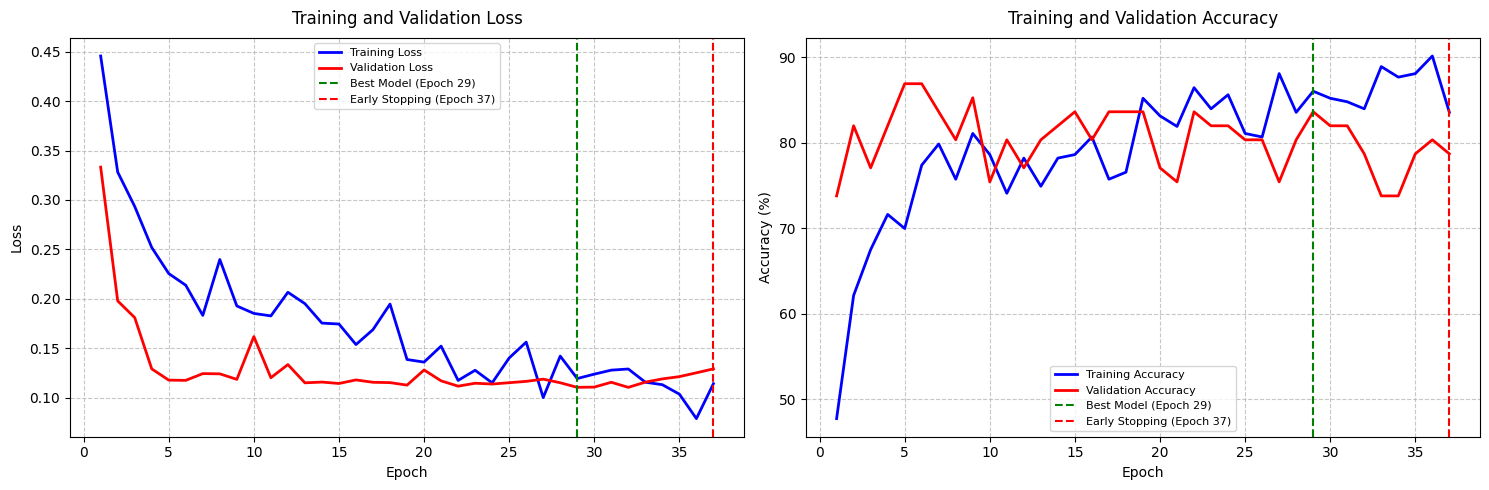

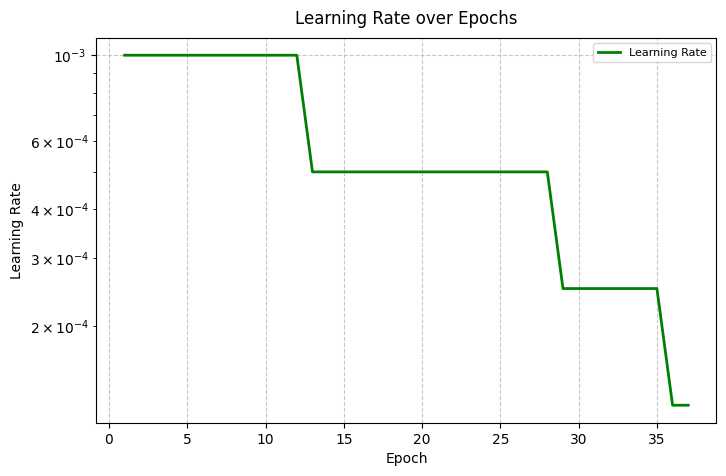


Training Metrics Summary:
Number of epochs trained: 37
Best validation loss: 0.1106 (Epoch 29)
Final validation loss: 0.1293
Best validation accuracy: 86.89%
Final validation accuracy: 78.69%

Plots saved in: wearnet_model_backbone/densenet121_custom_run_1/plots/figures
- Training metrics plot: wearnet_model_backbone/densenet121_custom_run_1/plots/figures/training_metrics.png
- Learning rate plot: wearnet_model_backbone/densenet121_custom_run_1/plots/figures/learning_rate.png


In [43]:
plot_metrics(metric_1, save_dir='wearnet_model_backbone/densenet121_custom_run_1/plots')

In [44]:
model_2, criterion_2, optimizer_2, scheduler_2 = setup_model(
model= WearNetWithBackbone(num_classes=config.NUM_CLASSES,backbone='resnet50'),
train_dataset=train_dataset)

In [45]:
metric_2,model_wearnet_resnet = train_model(model_2, train_loader, val_loader, criterion_2, optimizer_2, scheduler_2,
        num_epochs=config.EPOCHS, device=config.DEVICE,
        save_dir="wearnet_model_backbone_1", 
        run_name="resnet50_custom_run_1")

Training started. Files will be saved to: wearnet_model_backbone_1/resnet50_custom_run_1
Early stopping settings - Patience: 8, Tolerance: 0.0001


Epoch 1/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


New best model saved at epoch 1 with validation loss: 0.3118

Epoch 1/50:
Training Loss: 0.4480, Training Accuracy: 53.09%
Validation Loss: 0.3118, Validation Accuracy: 65.57%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 2/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


New best model saved at epoch 2 with validation loss: 0.2786

Epoch 2/50:
Training Loss: 0.3118, Training Accuracy: 64.20%
Validation Loss: 0.2786, Validation Accuracy: 67.21%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 3/50: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


New best model saved at epoch 3 with validation loss: 0.1427

Epoch 3/50:
Training Loss: 0.2629, Training Accuracy: 68.31%
Validation Loss: 0.1427, Validation Accuracy: 85.25%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 4/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



Epoch 4/50:
Training Loss: 0.2698, Training Accuracy: 68.72%
Validation Loss: 0.2900, Validation Accuracy: 67.21%
Learning Rate: 0.001000
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 5/50: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]



Epoch 5/50:
Training Loss: 0.2415, Training Accuracy: 72.43%
Validation Loss: 0.3145, Validation Accuracy: 77.05%
Learning Rate: 0.001000
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 6/50: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]



Epoch 6/50:
Training Loss: 0.2581, Training Accuracy: 72.84%
Validation Loss: 0.1781, Validation Accuracy: 75.41%
Learning Rate: 0.001000
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 7/50: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]


New best model saved at epoch 7 with validation loss: 0.1072

Epoch 7/50:
Training Loss: 0.2253, Training Accuracy: 72.84%
Validation Loss: 0.1072, Validation Accuracy: 83.61%
Learning Rate: 0.001000
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 8/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch 8/50:
Training Loss: 0.2345, Training Accuracy: 68.72%
Validation Loss: 0.1301, Validation Accuracy: 83.61%
Learning Rate: 0.001000
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 9/50: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]



Epoch 9/50:
Training Loss: 0.2412, Training Accuracy: 73.66%
Validation Loss: 0.1391, Validation Accuracy: 81.97%
Learning Rate: 0.001000
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 10/50: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]



Epoch 10/50:
Training Loss: 0.2220, Training Accuracy: 73.25%
Validation Loss: 0.1300, Validation Accuracy: 81.97%
Learning Rate: 0.001000
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 11/50: 100%|██████████| 8/8 [00:27<00:00,  3.40s/it]



Epoch 11/50:
Training Loss: 0.1895, Training Accuracy: 74.49%
Validation Loss: 0.1269, Validation Accuracy: 86.89%
Learning Rate: 0.001000
Early Stopping Counter: 4/8
--------------------------------------------------


Epoch 12/50: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]



Epoch 12/50:
Training Loss: 0.2128, Training Accuracy: 75.72%
Validation Loss: 0.1594, Validation Accuracy: 77.05%
Learning Rate: 0.001000
Early Stopping Counter: 5/8
--------------------------------------------------


Epoch 13/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch 13/50:
Training Loss: 0.1696, Training Accuracy: 75.72%
Validation Loss: 0.1929, Validation Accuracy: 73.77%
Learning Rate: 0.000500
Early Stopping Counter: 6/8
--------------------------------------------------


Epoch 14/50: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]



Epoch 14/50:
Training Loss: 0.1429, Training Accuracy: 81.89%
Validation Loss: 0.1806, Validation Accuracy: 80.33%
Learning Rate: 0.000500
Early Stopping Counter: 7/8
--------------------------------------------------


Epoch 15/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


Early stopping triggered after 15 epochs

[INFO] Loaded best model weights from epoch 7, val loss = 0.1072

Training Summary:
Status: early_stopped
Total Epochs Trained: 15
Best Validation Loss: 0.107176 (Epoch 7)
Final Validation Loss: 0.158791

Files saved to: wearnet_model_backbone_1/resnet50_custom_run_1
- Best model: wearnet_model_backbone_1/resnet50_custom_run_1/models/best_model.pth
- Final checkpoint: wearnet_model_backbone_1/resnet50_custom_run_1/models/final_checkpoint.pth
- Training metrics: wearnet_model_backbone_1/resnet50_custom_run_1/metrics/training_metrics.json
- Training status: wearnet_model_backbone_1/resnet50_custom_run_1/status/training_status.json


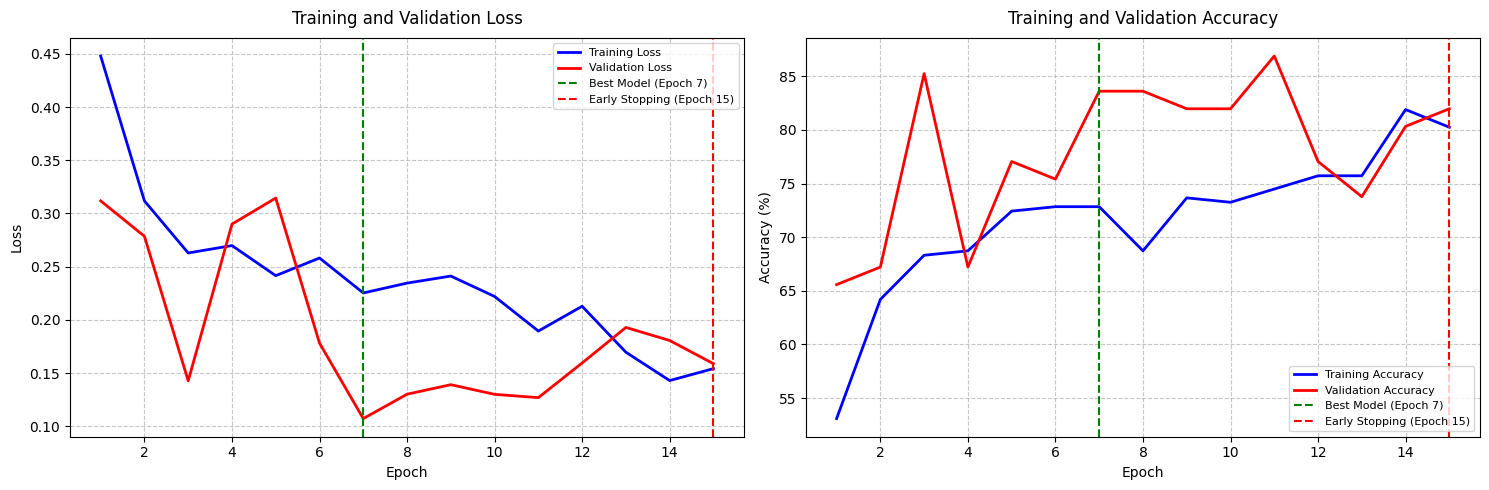

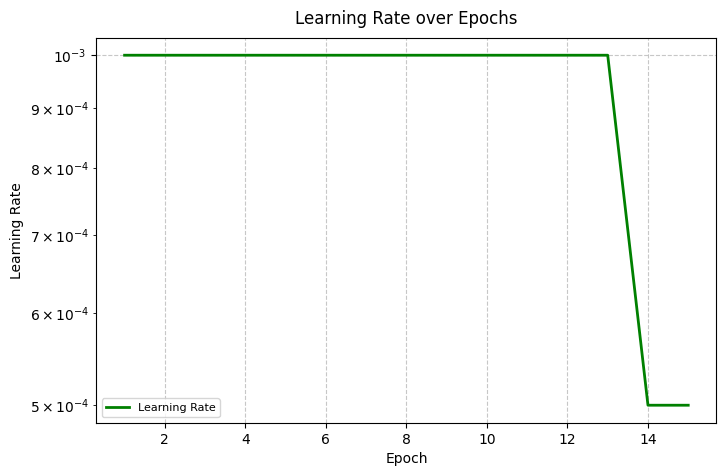


Training Metrics Summary:
Number of epochs trained: 15
Best validation loss: 0.1072 (Epoch 7)
Final validation loss: 0.1588
Best validation accuracy: 86.89%
Final validation accuracy: 81.97%

Plots saved in: wearnet_model_backbone_1/resnet50_custom_run_1/plots/figures
- Training metrics plot: wearnet_model_backbone_1/resnet50_custom_run_1/plots/figures/training_metrics.png
- Learning rate plot: wearnet_model_backbone_1/resnet50_custom_run_1/plots/figures/learning_rate.png


In [46]:
plot_metrics(metric_2, save_dir='wearnet_model_backbone_1/resnet50_custom_run_1/plots')

In [47]:
# Setup model with custom architecture and training dataset
# resnet50_model
model_3, criterion_3, optimizer_3, scheduler_3 = setup_model(
model= ResNet50Custom(num_classes=config.NUM_CLASSES),
train_dataset=train_dataset
)

In [48]:
metric_3,model_resnet = train_model(model_3, train_loader, val_loader, criterion_3, optimizer_3, scheduler_3,
        num_epochs=config.EPOCHS, device=config.DEVICE,
        save_dir="resnet_model", 
        run_name="resnet50_custom_run_1")

Training started. Files will be saved to: resnet_model/resnet50_custom_run_1
Early stopping settings - Patience: 8, Tolerance: 0.0001


Epoch 1/50: 100%|██████████| 8/8 [00:28<00:00,  3.53s/it]


New best model saved at epoch 1 with validation loss: 0.4751

Epoch 1/50:
Training Loss: 0.5239, Training Accuracy: 51.44%
Validation Loss: 0.4751, Validation Accuracy: 65.57%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 2/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


New best model saved at epoch 2 with validation loss: 0.3834

Epoch 2/50:
Training Loss: 0.3856, Training Accuracy: 62.96%
Validation Loss: 0.3834, Validation Accuracy: 62.30%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 3/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 3/50:
Training Loss: 0.2906, Training Accuracy: 66.26%
Validation Loss: 0.4075, Validation Accuracy: 62.30%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 4/50: 100%|██████████| 8/8 [00:27<00:00,  3.42s/it]


New best model saved at epoch 4 with validation loss: 0.2553

Epoch 4/50:
Training Loss: 0.3716, Training Accuracy: 64.20%
Validation Loss: 0.2553, Validation Accuracy: 65.57%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 5/50: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]


New best model saved at epoch 5 with validation loss: 0.1583

Epoch 5/50:
Training Loss: 0.2942, Training Accuracy: 67.90%
Validation Loss: 0.1583, Validation Accuracy: 75.41%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 6/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]



Epoch 6/50:
Training Loss: 0.2556, Training Accuracy: 70.37%
Validation Loss: 0.1904, Validation Accuracy: 80.33%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 7/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch 7/50:
Training Loss: 0.2632, Training Accuracy: 74.07%
Validation Loss: 0.1607, Validation Accuracy: 75.41%
Learning Rate: 0.000100
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 8/50: 100%|██████████| 8/8 [00:27<00:00,  3.39s/it]



Epoch 8/50:
Training Loss: 0.2388, Training Accuracy: 72.02%
Validation Loss: 0.1606, Validation Accuracy: 72.13%
Learning Rate: 0.000100
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 9/50: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


New best model saved at epoch 9 with validation loss: 0.1523

Epoch 9/50:
Training Loss: 0.2199, Training Accuracy: 72.02%
Validation Loss: 0.1523, Validation Accuracy: 77.05%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 10/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch 10/50:
Training Loss: 0.2216, Training Accuracy: 74.49%
Validation Loss: 0.1543, Validation Accuracy: 73.77%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 11/50: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch 11/50:
Training Loss: 0.2375, Training Accuracy: 73.66%
Validation Loss: 0.1690, Validation Accuracy: 81.97%
Learning Rate: 0.000100
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 12/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch 12/50:
Training Loss: 0.1891, Training Accuracy: 72.84%
Validation Loss: 0.1584, Validation Accuracy: 81.97%
Learning Rate: 0.000100
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 13/50: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]



Epoch 13/50:
Training Loss: 0.2247, Training Accuracy: 78.19%
Validation Loss: 0.1606, Validation Accuracy: 77.05%
Learning Rate: 0.000100
Early Stopping Counter: 4/8
--------------------------------------------------


Epoch 14/50: 100%|██████████| 8/8 [00:27<00:00,  3.44s/it]



Epoch 14/50:
Training Loss: 0.2070, Training Accuracy: 73.25%
Validation Loss: 0.1597, Validation Accuracy: 73.77%
Learning Rate: 0.000100
Early Stopping Counter: 5/8
--------------------------------------------------


Epoch 15/50: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]



Epoch 15/50:
Training Loss: 0.2130, Training Accuracy: 74.49%
Validation Loss: 0.2017, Validation Accuracy: 72.13%
Learning Rate: 0.000050
Early Stopping Counter: 6/8
--------------------------------------------------


Epoch 16/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]



Epoch 16/50:
Training Loss: 0.2245, Training Accuracy: 74.07%
Validation Loss: 0.1744, Validation Accuracy: 72.13%
Learning Rate: 0.000050
Early Stopping Counter: 7/8
--------------------------------------------------


Epoch 17/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


Early stopping triggered after 17 epochs

[INFO] Loaded best model weights from epoch 9, val loss = 0.1523

Training Summary:
Status: early_stopped
Total Epochs Trained: 17
Best Validation Loss: 0.152271 (Epoch 9)
Final Validation Loss: 0.167335

Files saved to: resnet_model/resnet50_custom_run_1
- Best model: resnet_model/resnet50_custom_run_1/models/best_model.pth
- Final checkpoint: resnet_model/resnet50_custom_run_1/models/final_checkpoint.pth
- Training metrics: resnet_model/resnet50_custom_run_1/metrics/training_metrics.json
- Training status: resnet_model/resnet50_custom_run_1/status/training_status.json


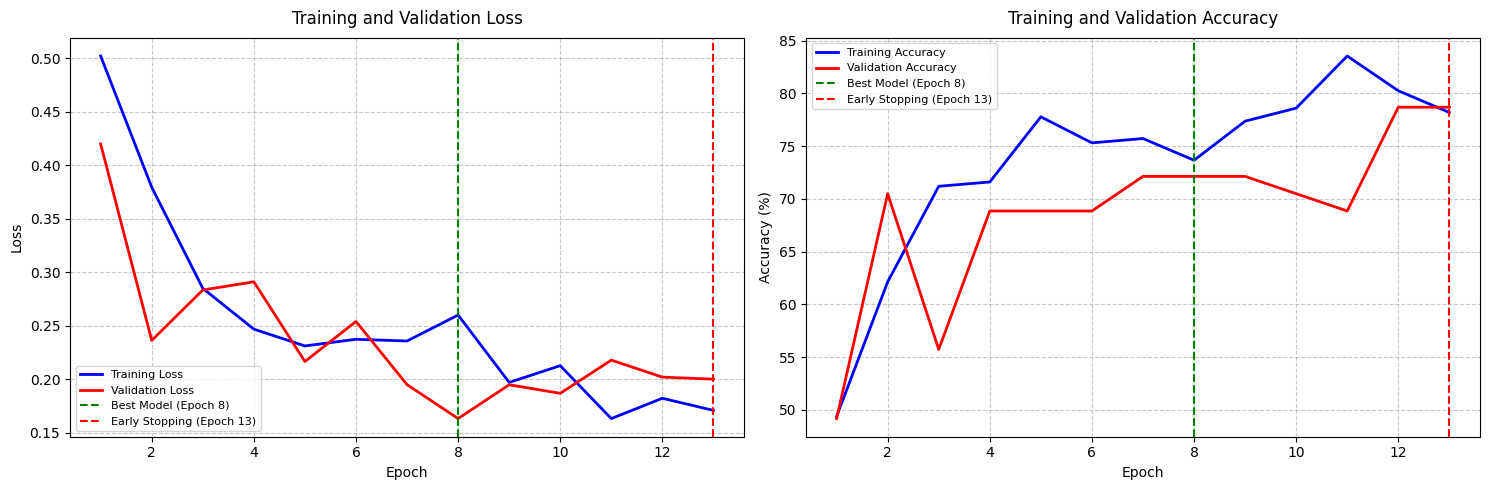

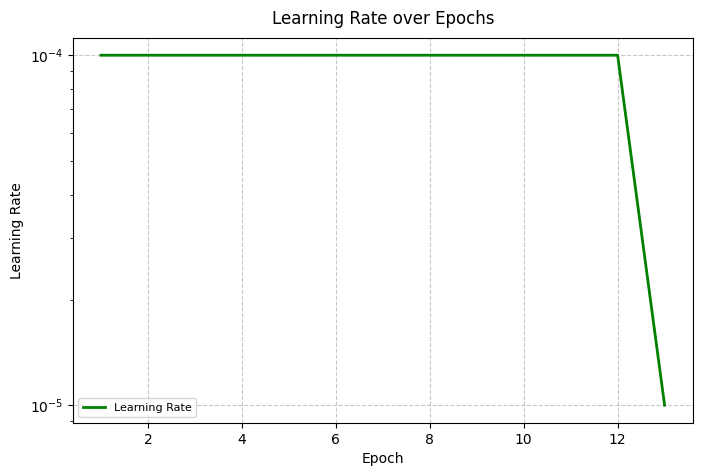


Training Metrics Summary:
Number of epochs trained: 13
Best validation loss: 0.1633 (Epoch 8)
Final validation loss: 0.2001
Best validation accuracy: 78.69%
Final validation accuracy: 78.69%

Plots saved in: resnet_model/resnet50_custom_run_1/plots/figures
- Training metrics plot: resnet_model/resnet50_custom_run_1/plots/figures/training_metrics.png
- Learning rate plot: resnet_model/resnet50_custom_run_1/plots/figures/learning_rate.png


In [ ]:
# Then plot the metrics
plot_metrics(metric_3, save_dir='resnet_model/resnet50_custom_run_1/plots')

In [50]:
# Setup model with custom MobileNetV2 architecture and training dataset
model_4, criterion_4, optimizer_4, scheduler_4 = setup_model(
    model=MobileNetV2Custom(num_classes=config.NUM_CLASSES),
    train_dataset=train_dataset
)

In [51]:
# Train the custom MobileNetV2 model and save training metrics and the best model
metric_4, model_mobilenet = train_model(
        model_4, train_loader, val_loader, criterion_4, optimizer_4, scheduler_4,
        num_epochs=config.EPOCHS, device=config.DEVICE,
        save_dir="mobilenet_model", 
        run_name="mobilenetv2_custom_run_1"
)

Training started. Files will be saved to: mobilenet_model/mobilenetv2_custom_run_1
Early stopping settings - Patience: 8, Tolerance: 0.0001


Epoch 1/50: 100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


New best model saved at epoch 1 with validation loss: 0.2693

Epoch 1/50:
Training Loss: 0.4325, Training Accuracy: 59.26%
Validation Loss: 0.2693, Validation Accuracy: 73.77%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 2/50: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]



Epoch 2/50:
Training Loss: 0.3913, Training Accuracy: 67.08%
Validation Loss: 0.3409, Validation Accuracy: 63.93%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 3/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


New best model saved at epoch 3 with validation loss: 0.2107

Epoch 3/50:
Training Loss: 0.3217, Training Accuracy: 68.72%
Validation Loss: 0.2107, Validation Accuracy: 75.41%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 4/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 4/50:
Training Loss: 0.2878, Training Accuracy: 66.26%
Validation Loss: 0.2114, Validation Accuracy: 77.05%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 5/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


New best model saved at epoch 5 with validation loss: 0.1720

Epoch 5/50:
Training Loss: 0.3342, Training Accuracy: 68.31%
Validation Loss: 0.1720, Validation Accuracy: 77.05%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 6/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


New best model saved at epoch 6 with validation loss: 0.1455

Epoch 6/50:
Training Loss: 0.2181, Training Accuracy: 77.37%
Validation Loss: 0.1455, Validation Accuracy: 85.25%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 7/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 7/50:
Training Loss: 0.2191, Training Accuracy: 78.60%
Validation Loss: 0.1721, Validation Accuracy: 77.05%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 8/50: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch 8/50:
Training Loss: 0.2494, Training Accuracy: 74.90%
Validation Loss: 0.1482, Validation Accuracy: 83.61%
Learning Rate: 0.000100
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 9/50: 100%|██████████| 8/8 [00:27<00:00,  3.39s/it]



Epoch 9/50:
Training Loss: 0.2584, Training Accuracy: 70.37%
Validation Loss: 0.1616, Validation Accuracy: 78.69%
Learning Rate: 0.000100
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 10/50: 100%|██████████| 8/8 [00:26<00:00,  3.31s/it]


New best model saved at epoch 10 with validation loss: 0.1405

Epoch 10/50:
Training Loss: 0.2202, Training Accuracy: 72.43%
Validation Loss: 0.1405, Validation Accuracy: 85.25%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 11/50: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch 11/50:
Training Loss: 0.2184, Training Accuracy: 77.78%
Validation Loss: 0.1427, Validation Accuracy: 81.97%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 12/50: 100%|██████████| 8/8 [00:27<00:00,  3.39s/it]


New best model saved at epoch 12 with validation loss: 0.1265

Epoch 12/50:
Training Loss: 0.1720, Training Accuracy: 79.01%
Validation Loss: 0.1265, Validation Accuracy: 86.89%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 13/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


New best model saved at epoch 13 with validation loss: 0.1240

Epoch 13/50:
Training Loss: 0.2045, Training Accuracy: 78.19%
Validation Loss: 0.1240, Validation Accuracy: 88.52%
Learning Rate: 0.000100
Early Stopping Counter: 0/8
--------------------------------------------------


Epoch 14/50: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch 14/50:
Training Loss: 0.2218, Training Accuracy: 78.19%
Validation Loss: 0.1363, Validation Accuracy: 88.52%
Learning Rate: 0.000100
Early Stopping Counter: 1/8
--------------------------------------------------


Epoch 15/50: 100%|██████████| 8/8 [00:27<00:00,  3.41s/it]



Epoch 15/50:
Training Loss: 0.2256, Training Accuracy: 75.31%
Validation Loss: 0.1356, Validation Accuracy: 83.61%
Learning Rate: 0.000100
Early Stopping Counter: 2/8
--------------------------------------------------


Epoch 16/50: 100%|██████████| 8/8 [00:26<00:00,  3.29s/it]



Epoch 16/50:
Training Loss: 0.1816, Training Accuracy: 78.19%
Validation Loss: 0.1300, Validation Accuracy: 81.97%
Learning Rate: 0.000100
Early Stopping Counter: 3/8
--------------------------------------------------


Epoch 17/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]



Epoch 17/50:
Training Loss: 0.1863, Training Accuracy: 75.72%
Validation Loss: 0.1299, Validation Accuracy: 81.97%
Learning Rate: 0.000100
Early Stopping Counter: 4/8
--------------------------------------------------


Epoch 18/50: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]



Epoch 18/50:
Training Loss: 0.1831, Training Accuracy: 77.78%
Validation Loss: 0.1399, Validation Accuracy: 78.69%
Learning Rate: 0.000100
Early Stopping Counter: 5/8
--------------------------------------------------


Epoch 19/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]



Epoch 19/50:
Training Loss: 0.1817, Training Accuracy: 81.48%
Validation Loss: 0.1575, Validation Accuracy: 73.77%
Learning Rate: 0.000050
Early Stopping Counter: 6/8
--------------------------------------------------


Epoch 20/50: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]



Epoch 20/50:
Training Loss: 0.1705, Training Accuracy: 78.60%
Validation Loss: 0.1494, Validation Accuracy: 81.97%
Learning Rate: 0.000050
Early Stopping Counter: 7/8
--------------------------------------------------


Epoch 21/50: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


Early stopping triggered after 21 epochs

[INFO] Loaded best model weights from epoch 13, val loss = 0.1240

Training Summary:
Status: early_stopped
Total Epochs Trained: 21
Best Validation Loss: 0.123986 (Epoch 13)
Final Validation Loss: 0.142810

Files saved to: mobilenet_model/mobilenetv2_custom_run_1
- Best model: mobilenet_model/mobilenetv2_custom_run_1/models/best_model.pth
- Final checkpoint: mobilenet_model/mobilenetv2_custom_run_1/models/final_checkpoint.pth
- Training metrics: mobilenet_model/mobilenetv2_custom_run_1/metrics/training_metrics.json
- Training status: mobilenet_model/mobilenetv2_custom_run_1/status/training_status.json


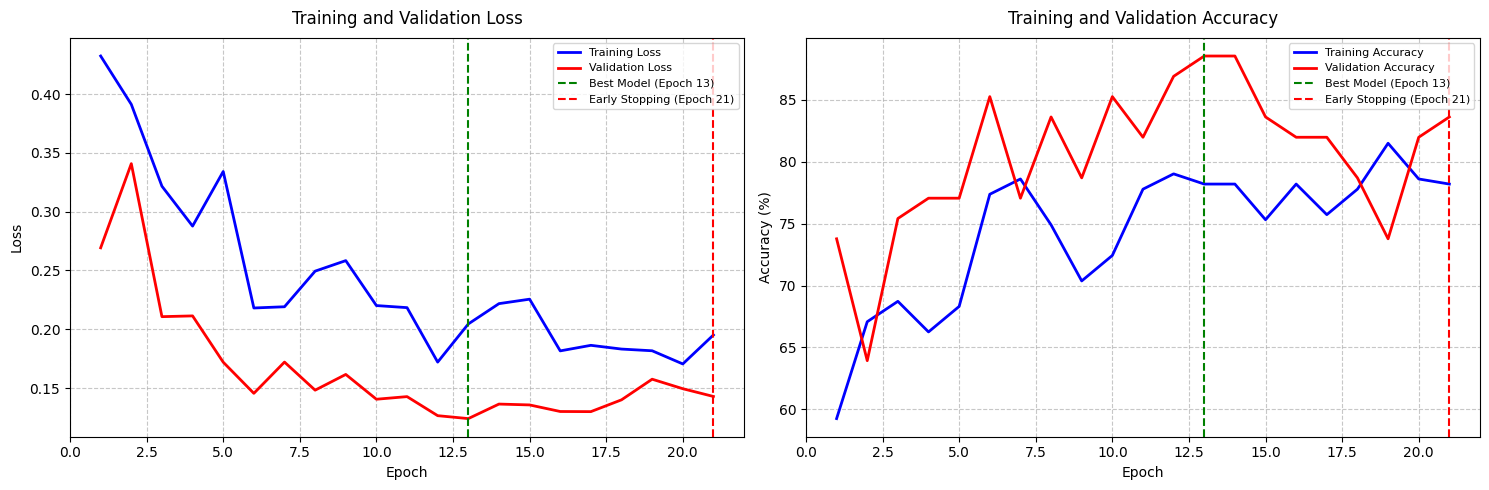

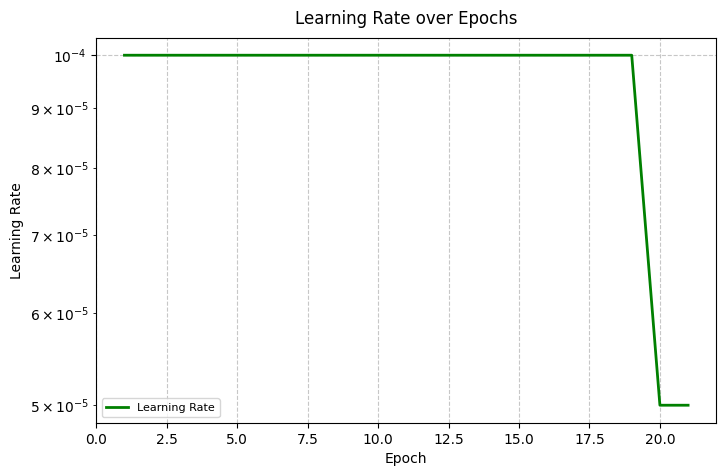


Training Metrics Summary:
Number of epochs trained: 21
Best validation loss: 0.1240 (Epoch 13)
Final validation loss: 0.1428
Best validation accuracy: 88.52%
Final validation accuracy: 83.61%

Plots saved in: mobilenet_model/mobilenetv2_custom_run_1/plots/figures
- Training metrics plot: mobilenet_model/mobilenetv2_custom_run_1/plots/figures/training_metrics.png
- Learning rate plot: mobilenet_model/mobilenetv2_custom_run_1/plots/figures/learning_rate.png


In [52]:
# Then plot the metrics
plot_metrics(metric_4, save_dir='mobilenet_model/mobilenetv2_custom_run_1/plots')

# Evaluation

The `evaluate_predictions` function provides a comprehensive assessment of model performance on a dataset:

- **Accuracy:**  
    Calculates the overall accuracy between predicted and true labels.

- **Confusion Matrix:**  
    Computes and prints the confusion matrix to visualize class-wise prediction results.

- **Classification Report:**  
    Generates a detailed report including precision, recall, and F1-score for each class.

- **Visualization:**  
    Optionally displays the confusion matrix as a heatmap for intuitive interpretation.

This evaluation is essential for understanding the strengths and weaknesses of the trained model and identifying areas for improvement.

In [53]:
def predict(model, data_loader, device='cuda'):
    """
    Generate predictions and probabilities for a given model and data loader.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to predict.
        device: Device to run inference on ('cuda', 'cpu', etc.).

    Returns:
        predictions: List of predicted class indices.
        probabilities: List of softmax probability arrays for each sample.
        true_labels: List of true class indices.
    """
    model.eval()  # Set model to evaluation mode
    predictions, probabilities, true_labels = [], [], []
    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in tqdm(data_loader, desc='Predicting'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities
            _, preds = torch.max(outputs, 1)       # Get predicted class indices
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, probabilities, true_labels



In [54]:
def evaluate_predictions(predictions, true_labels, class_names=None):
    """
    Evaluate predictions using accuracy, confusion matrix, and classification report.
    Optionally display a heatmap of the confusion matrix.

    Args:
        predictions (list or np.array): Predicted class indices.
        true_labels (list or np.array): True class indices.
        class_names (list, optional): List of class names for display.
    """
    # Convert to numpy arrays for compatibility
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    # Generate classification report
    classification_rep = classification_report(true_labels, predictions, target_names=class_names)
    
    # Print metrics
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", classification_rep)
    
    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Validation Confusion Matrix')
    plt.show()


# WearNet and Densenet 

In [55]:
preds, probs, true_labels = predict(model_wear_densenet, val_loader, device=config.DEVICE)

Predicting: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it]



Accuracy: 0.8361

Confusion Matrix:
 [[18  2  0]
 [ 2 15  4]
 [ 0  2 18]]

Classification Report:
               precision    recall  f1-score   support

Major_scrach       0.90      0.90      0.90        20
Minor_scrach       0.79      0.71      0.75        21
   no_scrach       0.82      0.90      0.86        20

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.83        61



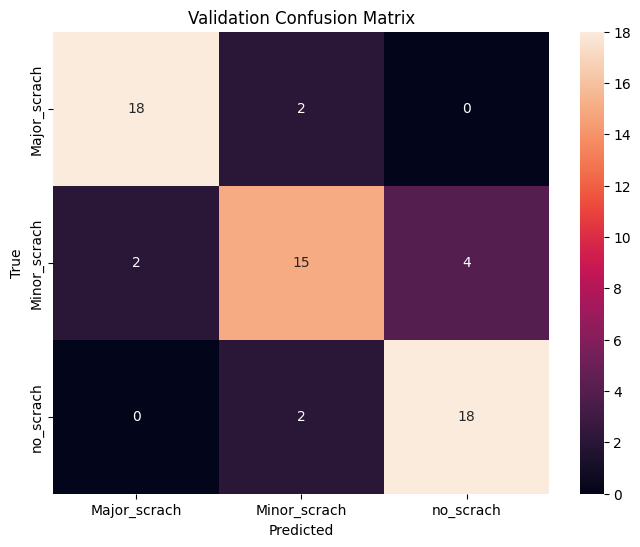

In [56]:
evaluate_predictions(preds, true_labels, class_names=config.CLASSES)

# Wearnet and Resnet50

In [57]:
preds, probs, true_labels = predict(model_wearnet_resnet, val_loader, device=config.DEVICE)

Predicting: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]



Accuracy: 0.8361

Confusion Matrix:
 [[17  3  0]
 [ 0 17  4]
 [ 0  3 17]]

Classification Report:
               precision    recall  f1-score   support

Major_scrach       1.00      0.85      0.92        20
Minor_scrach       0.74      0.81      0.77        21
   no_scrach       0.81      0.85      0.83        20

    accuracy                           0.84        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.84      0.84        61



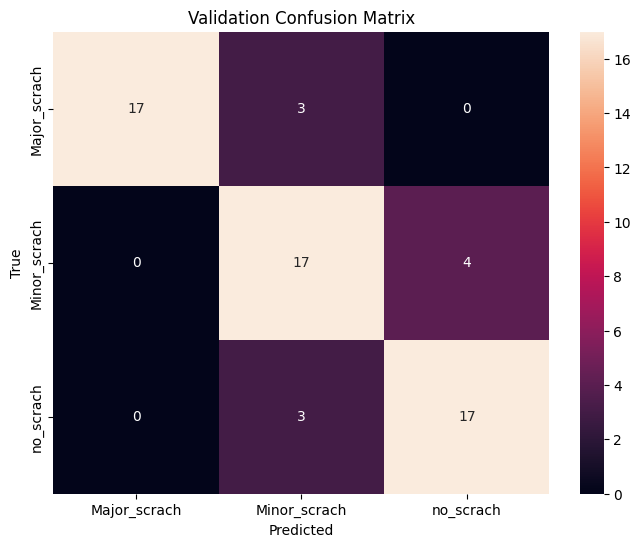

In [58]:
evaluate_predictions(preds, true_labels, class_names=config.CLASSES)

# Resnet 50

In [ ]:
preds, probs, true_labels = predict(model_resnet, val_loader, device=config.DEVICE)

Predicting: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it]



Accuracy: 0.7705

Confusion Matrix:
 [[18  2  0]
 [ 4 13  4]
 [ 0  4 16]]

Classification Report:
               precision    recall  f1-score   support

Major_scrach       0.82      0.90      0.86        20
Minor_scrach       0.68      0.62      0.65        21
   no_scrach       0.80      0.80      0.80        20

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



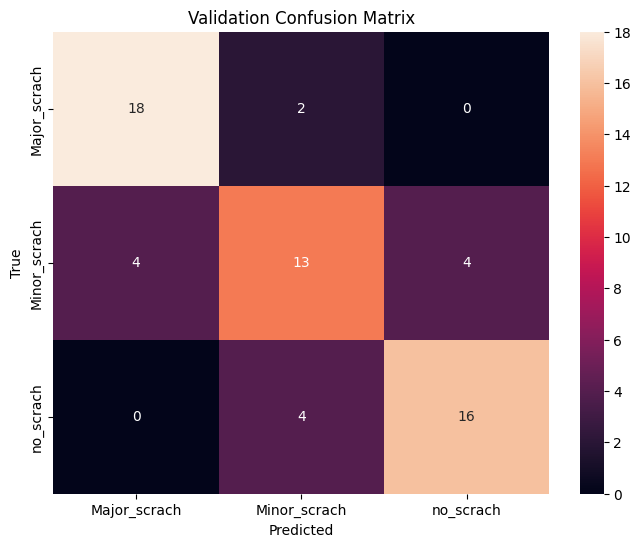

In [60]:
evaluate_predictions(preds, true_labels, class_names=config.CLASSES)

In [61]:
preds_1, probs_1, true_labels_1 = predict(model_mobilenet, val_loader, device=config.DEVICE)

Predicting: 100%|██████████| 2/2 [00:14<00:00,  7.28s/it]



Accuracy: 0.8852

Confusion Matrix:
 [[17  3  0]
 [ 1 19  1]
 [ 0  2 18]]

Classification Report:
               precision    recall  f1-score   support

Major_scrach       0.94      0.85      0.89        20
Minor_scrach       0.79      0.90      0.84        21
   no_scrach       0.95      0.90      0.92        20

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.89        61
weighted avg       0.89      0.89      0.89        61



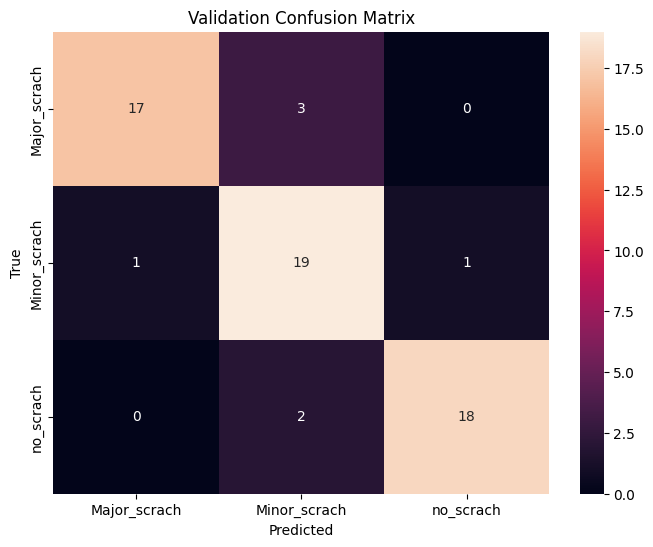

In [62]:
evaluate_predictions(preds_1, true_labels_1, class_names=config.CLASSES)